In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import colorcet
import cycler
import pandas as pd
import rubin_sim.photUtils as photUtils
from rubin_sim.data import get_data_dir

For a starting point, let's demonstrate going from a reflectance spectra to an observed SED, and then observed colors (in LSST and/or other systems) using rubin_sim. 

In [2]:
# We have some sample asteroid spectra in rubin_sim_data_dir - this is what 'get_data_dir' returns.
# However, those are 'observed' spectra (already includes a sample solar spectra)
ast_templates = [k.replace('.dat.gz', '') for k in os.listdir(os.path.join(get_data_dir(), 'movingObjects')) 
                 if 'kurucz' not in k and 'harris' not in k]

In [3]:
# Read the sso seds from disk (using rubin_sim.photUtils.Sed)
sso = {}
for k in ast_templates:
    sso[k]= photUtils.Sed()
    sso[k].readSED_flambda(os.path.join(get_data_dir(), 'movingObjects', f'{k}.dat.gz'))

# Read the sun too
sun = photUtils.Sed()
sun.readSED_flambda(os.path.join(get_data_dir(), 'movingObjects', 'kurucz_sun.gz'))

Text(0, 0.5, 'F_lambda  (ergs/cm^s/s/nm)')

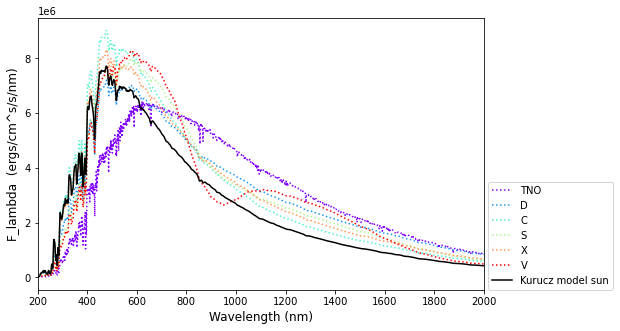

In [4]:
# Let's visualize, with maybe a better way of cycling through the colors for the linestyles

fig = plt.figure(figsize=(8, 5))
ax = plt.gca()

# Pick a subset to plot to make it less confusing
subset = ['TNO', 'D', 'C', 'S', 'X', 'V']
color = cm.rainbow(np.linspace(0, 1, len(subset)))
ax.set_prop_cycle(cycler.cycler('color', color))

# Normalize the SEDs so they fit on the same plot but still make a bit more sense
# This particular normalization essentially makes all of the objects (and the sun) have
# the same total flux over the wwavelen_min to wwavelen_max window
wwavelen_min = 200
wwavelen_max = 2000
sun_window = np.where((sun.wavelen > wwavelen_min) & (sun.wavelen < wwavelen_max))
sun_max = sun.flambda[sun_window].mean()

for k in subset:
    sso_window = np.where((sso[k].wavelen > wwavelen_min) & (sso[k].wavelen < wwavelen_max))
    norm = sun_max / (sso[k].flambda[sso_window].mean())
    plt.plot(sso[k].wavelen, sso[k].flambda * norm, label=k, linestyle=':')
plt.plot(sun.wavelen, sun.flambda, 'k',  linestyle='-', label='Kurucz model sun')
plt.legend(loc=(1.01, 0.0))
plt.xlim(200, 2000)
plt.xlabel('Wavelength (nm)', fontsize='large')
plt.ylabel('F_lambda  (ergs/cm^s/s/nm)', fontsize='large')

With these 'observed' spectra, it's pretty straight forward to calculate expected magnitudes in the LSST bandpasses.

(0.0, 1.0)

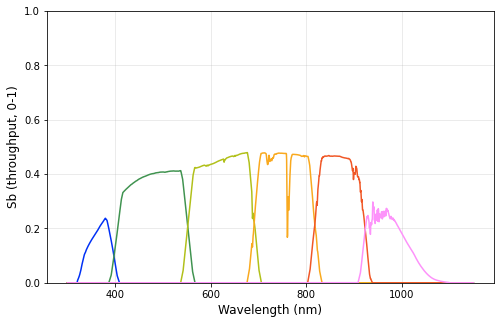

In [5]:
# Read in the lsst total system bandpasses (this is QE, filters, telescope and sample atmosphere)
lsst = {}
lsst_filterlist = 'ugrizy'
for f in lsst_filterlist:
    lsst[f] = photUtils.Bandpass()
    lsst[f].readThroughput(os.path.join(get_data_dir(), 'throughputs', 'baseline', f'total_{f}.dat'))

cmap = colorcet.cm['CET_R1'](np.linspace(0, 1, len(lsst_filterlist)))

fig = plt.figure(figsize=(8,5))
for i, f in enumerate(lsst_filterlist):
    plt.plot(lsst[f].wavelen, lsst[f].sb, color=cmap[i])
plt.xlabel('Wavelength (nm)', fontsize='large')
plt.ylabel('Sb (throughput, 0-1)', fontsize='large')
plt.grid(alpha=0.3)
plt.ylim(0, 1)

In [6]:
# Note that we can also read in other bandpasses from the throughputs directory -- 
os.listdir(os.path.join(get_data_dir(), 'throughputs'))

['sdss',
 'megacam',
 'imsim',
 'baseline',
 'panStarrs',
 'atmos',
 'README.md',
 '2MASS',
 'tycho',
 'WISE',
 'approximate_baseline',
 'johnson',
 'hipparcos']

(0.0, 1.0)

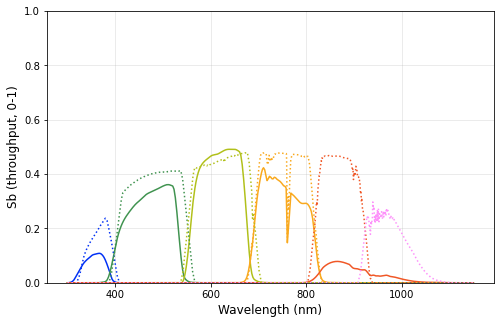

In [7]:
# Read in the sdss total system bandpasses (this is QE, filters, telescope and sample atmosphere, again)
sdss = {}
sdss_filterlist = 'ugriz'
for f in sdss_filterlist:
    sdss[f] = photUtils.Bandpass()
    sdss[f].readThroughput(os.path.join(get_data_dir(), 'throughputs', 'sdss', f'sdss_{f}.dat'))

cmap = colorcet.cm['CET_R1'](np.linspace(0, 1, len(lsst_filterlist)))

fig = plt.figure(figsize=(8,5))
for i, f in enumerate(sdss_filterlist):
    plt.plot(sdss[f].wavelen, sdss[f].sb, color=cmap[i])
for i, f in enumerate(lsst_filterlist):
    plt.plot(lsst[f].wavelen, lsst[f].sb, linestyle=':', color=cmap[i])
plt.xlabel('Wavelength (nm)', fontsize='large')
plt.ylabel('Sb (throughput, 0-1)', fontsize='large')
plt.grid(alpha=0.3)
plt.ylim(0, 1)

Calculating magnitudes in each of these bandpasses. 

Note that really we're looking for colors, so the overall normalization of the fluxes for each object (or the magnitudes in any given band) are not important; just the relative differences of the magnitudes. We'll use 'lsst r' as the reference for now. 

In [8]:
refband_name = 'r'
refband = lsst[refband_name]

# Calculate the reference bandpass magnitudes
refmags = {}
for k in sso:
    refmags[k] = sso[k].calcMag(refband)

# Calculate the colors
colors = {}
for k in sso:
    colors[k] = {}
    for f in lsst_filterlist:
        colors[k][f'lsst_{f}'] = sso[k].calcMag(lsst[f]) - refmags[k]
        
        
# Let's calculate colors for SDSS -- but let's update refband so we're using sdss r 
refband = sdss[refband_name]

# Calculate the reference bandpass magnitudes
refmags = {}
for k in sso:
    refmags[k] = sso[k].calcMag(refband)

# Calculate the colors
for k in sso:
    for f in sdss_filterlist:
        colors[k][f'sdss_{f}'] = sso[k].calcMag(sdss[f]) - refmags[k]

In [9]:
df_colors = pd.DataFrame(colors)
df_colors

,D,R,TNO,Cg,Sv,B,V,Sr,Cgh,L,...,Ch,K,Xk,S,Cb,Xc,O,C,A,Sq
lsst_u,1.904652,2.206750,2.548508,1.931740,2.070095,1.688083,2.233633,2.179799,1.917585,2.105767,...,1.736446,1.977124,1.802801,2.129080,1.598896,1.806788,1.886488,1.723571,2.530651,2.107818
lsst_g,0.577264,0.693363,0.915011,0.541108,0.645732,0.460440,0.695886,0.655136,0.516036,0.653234,...,0.456163,0.592332,0.521171,0.654205,0.436608,0.516802,0.532195,0.476202,0.794241,0.637479
lsst_r,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
lsst_i,-0.211503,-0.172324,-0.381887,-0.109209,-0.224038,-0.087457,-0.152789,-0.174388,-0.106343,-0.205424,...,-0.101523,-0.168721,-0.150836,-0.192314,-0.123852,-0.152902,-0.084650,-0.114002,-0.218935,-0.163748
lsst_z,-0.298785,0.031676,-0.588997,-0.106706,-0.160094,-0.063236,0.167049,-0.071307,-0.136510,-0.221906,...,-0.125378,-0.145809,-0.170075,-0.135177,-0.144257,-0.183496,0.147843,-0.119666,-0.138150,-0.078562
lsst_y,-0.389105,0.055530,-0.699987,-0.112148,-0.195119,-0.044676,0.152775,-0.086032,-0.166098,-0.245780,...,-0.145141,-0.132430,-0.204687,-0.144213,-0.160145,-0.205868,0.291362,-0.124417,-0.044370,-0.052835
sdss_u,2.024160,2.348615,2.701873,2.068506,2.199047,1.803102,2.380326,2.328208,2.058616,2.240857,...,1.859988,2.106106,1.920398,2.268211,1.703995,1.925979,2.016140,1.839828,2.707846,2.248214
sdss_g,0.616040,0.740380,0.975935,0.584442,0.687729,0.496791,0.743471,0.701442,0.559530,0.697735,...,0.493954,0.634196,0.558659,0.699476,0.468696,0.554317,0.573048,0.512695,0.849171,0.682735
sdss_r,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sdss_i,-0.214031,-0.183585,-0.384183,-0.110768,-0.230502,-0.089177,-0.165173,-0.181286,-0.106134,-0.210372,...,-0.101440,-0.173147,-0.153275,-0.198426,-0.125105,-0.154902,-0.091638,-0.115552,-0.229485,-0.170191


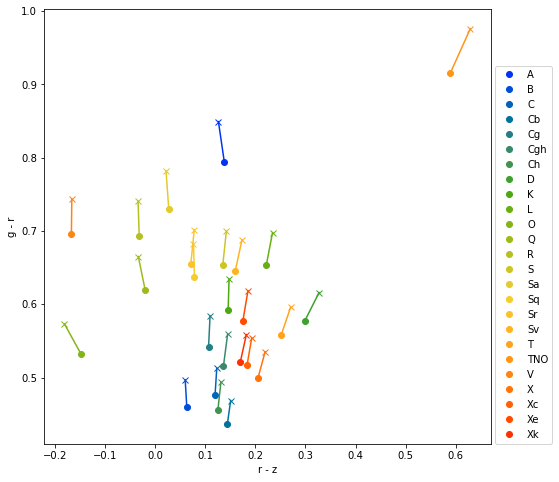

In [10]:
# Plot some color-color combinations
c1 = 'lsst_g'  #g-r
cc1 = 'sdss_g'
c2 = 'lsst_z'  #z-r .. we'll flip so it's r-z
cc2 = 'sdss_z'

fig = plt.figure(figsize=(8,8)) 
cmap = colorcet.cm['CET_R2'](np.linspace(0, 1, len(sso)))

sso_keys = sorted(list(sso.keys()))
for i, k in enumerate(sso_keys):
    c = cmap[i]
    plt.plot(-colors[k][c2], colors[k][c1], linestyle='', marker='o', color=c, label=k)
    plt.plot(-colors[k][cc2], colors[k][cc1], linestyle='', marker='x', color=c)
    plt.plot([-colors[k][c2], -colors[k][cc2]],
            [colors[k][c1], colors[k][cc1]], linestyle='-', marker='', color=c)
plt.xlabel(f"{refband_name} - {c2.replace('lsst_', '')}")
plt.ylabel(f"{c1.replace('lsst_', '')} - {refband_name}")
plt.legend(loc=(1.01, 0.0))

So that's interesting and I'm not sure I quite understand what's going on. It's likely understandable that $z$ band colors change, as the $z$ bands in LSST are fairly different from SDSS. But this seems to show a big change in g-r colors as well, which I wasn't expecting.